# 심층학습 [실습04] 심층신경망 훈련
### (2) Data augmentation - 201911019 최현민
---

### CIFAR10 을 CNN 으로 학습하기. 여러 학습 방법으로 비교

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 1

### 1. CIFAR10 train, test dataset 가져오기 (163 MB)

In [2]:
#cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# (2) Data augmentation
cifar_train=dset.CIFAR10("CIFAR10/", train=True, download = True,
                         transform = transforms.Compose([
                                 transforms.Scale(36),
                                 transforms.CenterCrop(32),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Lambda(lambda x: x.rotate(90)),
                                 transforms.ToTensor()
                                                                           
                         ]))
cifar_test=dset.CIFAR10("CIFAR10/", train = False, transform=transforms.ToTensor(), target_transform=None, download=True)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified
Files already downloaded and verified


### 2. 대략적인 데이터 형태

cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


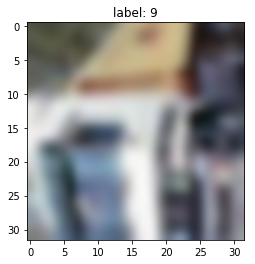

In [3]:
print "cifar_train 길이:", len(cifar_train)
print "cifar_test 길이:", len(cifar_test)

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1)   # 1번째 데이터
print "image data 형태:", image.size()
print "label:", label

# 그리기
img = image.numpy()   # image 타입을 numpy로 변환 (3,32,32)

# (3,32,32) -> (32,32,3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):   # batch_size 만큼
        img = Variable(imgs)   # x
        # label = Varibale(labels)   # y
        label = Variable(labels)
        # .cuda() : GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남
        
        output = imodel.forward(img)   # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

### 3. 데이터 로드함수

In [5]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

### 4. 모델 선언

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0,2),   # (2) drop out
            #nn.BatchWorm2d(16),   # (6) Batch normalization
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0,2),
            #nn.BatchWorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0,2),
            #nn.BatchWorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            #nn.Dropout2d(0,2),
            #nn.BatchWorm2d(100),
            nn.Linear(100,10)
        )
    
    def forward(self, w):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out=self.fc_layer(out)
        
        return out
model=CNN()

### 5. loss, optimizer

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### 6. 학습

In [8]:
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)

        optimizer.zero_grad()
        output=model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j%1000 ==0:
            print(j, loss)

(0, tensor(2.3120, grad_fn=<NllLossBackward>))
(1000, tensor(2.2860, grad_fn=<NllLossBackward>))
(2000, tensor(2.2696, grad_fn=<NllLossBackward>))
(3000, tensor(2.2088, grad_fn=<NllLossBackward>))


### (2) Data augmentation

In [9]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 10.1000003815
